<a href="https://colab.research.google.com/github/sesidhar-7/final_proj/blob/main/vit-dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install vit-keras tensorflow-addons tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━

In [3]:


# Install necessary libraries
!pip install vit-keras tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 25.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [14]:
import kagglehub


In [15]:
# Constants
TARGET_SIZE = (224, 224)  # Updated size for better medical image analysis
BATCH_SIZE = 16
LR = 0.001  # Initial learning rate
EPOCHS = 1  # Training epochs for a demo
ROOT_DIRECTORY = kagglehub.dataset_download("sabari50312/fundus-pytorch")

print("Path to dataset files:", ROOT_DIRECTORY)


Path to dataset files: /root/.cache/kagglehub/datasets/sabari50312/fundus-pytorch/versions/1


In [16]:
# Dataset Preparation with Augmentation
def read_dataset(path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    train_dataset = datagen.flow_from_directory(
        os.path.join(path, "train"), target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
    test_dataset = datagen.flow_from_directory(
        os.path.join(path, "test"), target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
    val_dataset = datagen.flow_from_directory(
        os.path.join(path, "val"), target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
    return train_dataset, test_dataset, val_dataset

train_dataset, test_dataset, val_dataset = read_dataset(ROOT_DIRECTORY)

Found 8621 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.


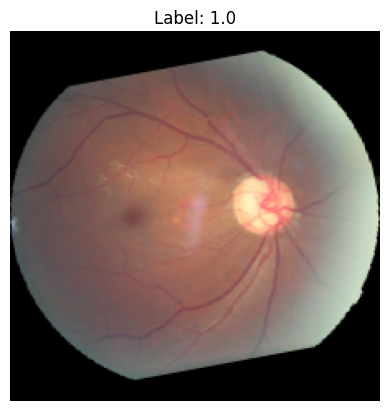

In [17]:
# Visualization
images, labels = next(train_dataset)
plt.imshow(images[0])
plt.title("Label: " + str(labels[0]))
plt.axis('off')
plt.show()


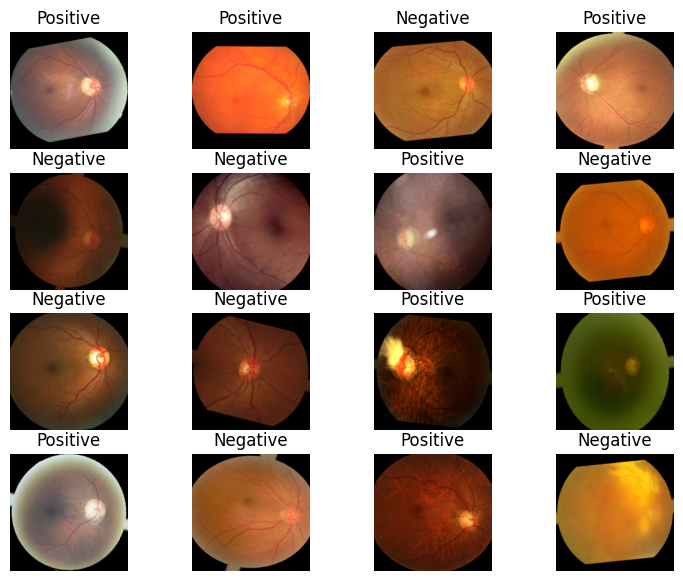

In [18]:
n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(9, 7))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(images[i * n_cols + j])
        ax[i][j].set_title("Positive" if labels[i * n_cols + j] == 1.0 else "Negative")
        ax[i][j].axis("off")
plt.show()

In [20]:
# Import necessary libraries
import pandas as pd
from tabulate import tabulate

In [1]:

# ViT-DR Model Definition
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    print("Building ViT-DR model...\n")

    # Load ViT Base model (pretrained on ImageNet21k)
    base_model = vit.vit_b16(
        image_size=224,
        activation='sigmoid',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=2
    )

    # Add custom layers
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

    # Compile model with RMSprop and cosine decay learning rate
    lr_schedule = CosineDecay(initial_learning_rate=LR, decay_steps=10000, alpha=0.1)
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')  # Using native TensorFlow AUC
        ]
    )

    # Model summary with table-like display
    model.summary()
    model_table = []
    for layer in model.layers:
        model_table.append([layer.name, layer.output_shape, layer.count_params()])
    df = pd.DataFrame(model_table, columns=["Layer Name", "Output Shape", "Param #"])
    print(tabulate(df, headers='keys', tablefmt='pretty'))

# Callbacks for Early Stopping and Learning Rate Adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the ViT-DR Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
results = model.evaluate(test_dataset, verbose=1)
print("Test Results - Loss: {:.4f}, Accuracy: {:.4f}, AUC: {:.4f}".format(*results))


NameError: name 'tf' is not defined